# Capstone Project - The Battle of Neighborhoods
By Erik Costello (not a Data Scientist)

Explore and cluster the neighborhoods in Toronto. I will work with only boroughs that contain the word Toronto and then replicate the same analysis we did to the New York City data.

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## First setup the choropleth map of the target (Montgomery County)

#### Use geopy library to get the latitude and longitude values
In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>my_explorer</em>, and load the townships population data to give an indication of the customer base 
for breweries in different townships.

In [280]:
geolocator = Nominatim(user_agent="my_explorer")

# function to get lat and long.
def get_latlong(name) :
    location = geolocator.geocode(name)
    latitude = location.latitude
    longitude = location.longitude
    #print('The geograpical coordinates of {} are {}, {}.'.format(name, latitude, longitude))
    return latitude, longitude


In [281]:
townships = pd.read_csv('Mont-townships.csv')
townships.head()

,Townships,Population 2010
0,Abington,55310
1,Ambler,6417
2,Bridgeport,4554
3,Bryn Athyn,1375
4,Cheltenham,36793


In [282]:
town_coords = []
for i in range(len(townships)) :
    town_coords.append( get_latlong(townships.iloc[i,0]+', PA') )
    #print(townships.iloc[i,0]+', PA')

In [283]:
tc = pd.DataFrame(town_coords, columns=['Latitude','Longitude'])
tc.head()

,Latitude,Longitude
0,40.120666,-75.117951
1,40.154553,-75.221565
2,40.104304,-75.342952
3,40.131499,-75.067394
4,40.060944,-75.094063


In [284]:
neighborhoods = pd.concat([townships, tc], axis=1)

# convert all township names to upper case as choropleth maps needs an exact match
neighborhoods['Townships'] = neighborhoods['Townships'].apply(lambda x: x.upper())

neighborhoods.tail()

,Townships,Population 2010,Latitude,Longitude
56,WEST NORRITON,15663,40.129551,-75.378517
57,WEST POTTSGROVE,3874,40.254539,-75.684632
58,WHITEMARSH,17349,40.122054,-75.216566
59,WHITPAIN,18875,40.157707,-75.276007
60,WORCESTER,9750,40.201217,-75.346567


In [285]:
address = 'Montgomery County, PA'
latitude, longitude = get_latlong(address) 

In [290]:
choro_map = folium.Map(location=[latitude, longitude], zoom_start=10)  #tiles='Mapbox Bright'
mont_geo = r'PaMunicipalities2019_46.json'
folium.Choropleth(
    geo_data=mont_geo,
    data=neighborhoods,
    columns=['Townships', 'Population 2010'],
    key_on='feature.properties.MUNICIPAL1',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
).add_to(choro_map)

choro_map

# Next, build the list of Breweries using Foursquare API 

In [100]:
#Define Foursquare Credentials and Version
CLIENT_ID = 'XGVAPINFVWDTFQRAST5BWLHIH2AJUNYOPB2D5CVOTEZUKAKW' # your Foursquare ID
CLIENT_SECRET = '1GOPCZRH3KI44HJRXDLMARI3RFY0TLVHRC1TWC44POHCNHWU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [291]:
LIMIT = 100

In [292]:
# Define Foursquare Credentials and Version
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

## First search for breweries and brew-pubs, bars, pubs.

Foursquare results using the query method of searching provides poor results based on searches for Brewery.  In fact, it missed my top 5 breweries within 12 miles based on that search.  It provided even worse results based on 'brewpub', 'brew-pub' and 'gastropub'.  In reading the API documentation, I found that there is a categoryId == 'Brewery'.  This is what returns good results with minor junk locations.  Since montgomery county is narrow and tall, i'll gather locations in two chunks and combine them.

In [409]:
radius = 22736   # 14 miles is the effective radius of Montgomery county.  Any more and I'll get other counties.

categoryId = '50327c8591d4c4b30a586d5d'  # this is a brewery
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}&intent=browse'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, categoryId, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=XGVAPINFVWDTFQRAST5BWLHIH2AJUNYOPB2D5CVOTEZUKAKW&client_secret=1GOPCZRH3KI44HJRXDLMARI3RFY0TLVHRC1TWC44POHCNHWU&ll=40.2154361,-75.3702305&v=20180605&categoryId=50327c8591d4c4b30a586d5d&radius=22736&limit=100&intent=browse'

In [410]:
results = requests.get(url).json()

# assign relevant part of JSON to venues
lower_venues = results['response']['venues']

In [411]:
# Second data chunk for upper county breweries 
radius = 8000   # 5 miles to fill the top of the county
latitude =  40.228214
longitude = -75.470950
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}&intent=browse'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, categoryId, radius, LIMIT)
results = requests.get(url).json()
upper_venues = results['response']['venues']


In [412]:
# tranform venues into a dataframe
dataframe1 = json_normalize(lower_venues)
dataframe2 = json_normalize(upper_venues)

# combine the dataframes
dataframe = pd.concat([dataframe1, dataframe2], ignore_index=True, sort=False)


In [413]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [414]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered = dataframe_filtered.drop('labeledLatLngs', axis=1)
dataframe_filtered = dataframe_filtered.drop('distance', axis=1)
dataframe_filtered = dataframe_filtered.drop('crossStreet', axis=1)
dataframe_filtered = dataframe_filtered.drop('country', axis=1)
dataframe_filtered = dataframe_filtered.drop('state', axis=1)
dataframe_filtered = dataframe_filtered.drop('cc', axis=1)
dataframe_filtered = dataframe_filtered.drop('formattedAddress', axis=1)


In [415]:
#dataframe_filtered.reset_index()

dataframe_filtered = dataframe_filtered.drop_duplicates()
dataframe_filtered

,name,categories,address,city,lat,lng,postalCode,id
0,Imprint Beer Co.,Brewery,1500 Industry Rd Ste O,Hatfield,40.264030,-75.283990,19440,5a5a8235b9a5a867e3567816
1,Root Down Brewing Company,Brewery,1 N Main St,Phoenixville,40.134446,-75.516047,19460,5980fde3123a1927c160b4a7
2,free will brewing co.,Brewery,410 E Walnut St,Perkasie,40.365293,-75.288001,18944,502fa34be4b0c51825ba409b
3,Workhorse Brewing Co.,Brewery,250 King Manor Dr,King of Prussia,40.091376,-75.349277,19406,5b9c1b41911fc4003971ec43
4,Blueprint Brew Co,Brewery,1571 Gehman Rd,Harleysville,40.254252,-75.344509,19438,59555ffe178a2a234aa3f6a5
5,Iron Hill Brewery & Restaurant,Brewery,8400 Germantown Ave,Philadelphia,40.075210,-75.205261,19118,4eefd928a69ddc7bcb5caefa
6,Stable 12 Brewing Company,Brewery,368 Bridge St,Phoenixville,40.132923,-75.520894,19460,54e0ed07498eda4a05ead0b1
7,The Pour House,Beer Bar,29 Airport Sq,North Wales,40.238277,-75.241587,19454,55fb4a74498ec35020c13550
8,Bald Birds Brewing Co.,Brewery,970 Rittenhouse Rd Ste 400,Audubon,40.126357,-75.416254,19403,5b804a7a46e1b6002c0a1576
9,Forest & Main Brewing Company,Brewery,61 N Main St,Ambler,40.155337,-75.225180,19002,4f10714ce4b0d59e1eea5323


# Clean the brewery list

Now we have the breweries within the target zone.  

First, need to clean this data.  There are a few locations that do not really qualify as Breweries, such as brewery supplies and people who faked out Foursquare and said their house was a brewery because they made a batch of beer in their basement.

### drop locations that are not breweries:
'Red Barn Brewing Company', 'Hot Potato Brewhouse', 'Bob's Cases & Kegs', 'Towamencin Beverage', 
'Brewer's Outlet', 'Craft Ale House', 'The Pour House', 'Mad River'
### drop locations that are out of the target range:
'Geronimo Brewing @ Lilly's Jury Room', and 'free will brewing co' because it is way out of the county 


In [416]:
# drop any location without a valid value as those are likely not real places
dataframe_filtered.dropna(axis=0, how='any', inplace=True)
dataframe_filtered

,name,categories,address,city,lat,lng,postalCode,id
0,Imprint Beer Co.,Brewery,1500 Industry Rd Ste O,Hatfield,40.264030,-75.283990,19440,5a5a8235b9a5a867e3567816
1,Root Down Brewing Company,Brewery,1 N Main St,Phoenixville,40.134446,-75.516047,19460,5980fde3123a1927c160b4a7
2,free will brewing co.,Brewery,410 E Walnut St,Perkasie,40.365293,-75.288001,18944,502fa34be4b0c51825ba409b
3,Workhorse Brewing Co.,Brewery,250 King Manor Dr,King of Prussia,40.091376,-75.349277,19406,5b9c1b41911fc4003971ec43
4,Blueprint Brew Co,Brewery,1571 Gehman Rd,Harleysville,40.254252,-75.344509,19438,59555ffe178a2a234aa3f6a5
5,Iron Hill Brewery & Restaurant,Brewery,8400 Germantown Ave,Philadelphia,40.075210,-75.205261,19118,4eefd928a69ddc7bcb5caefa
6,Stable 12 Brewing Company,Brewery,368 Bridge St,Phoenixville,40.132923,-75.520894,19460,54e0ed07498eda4a05ead0b1
7,The Pour House,Beer Bar,29 Airport Sq,North Wales,40.238277,-75.241587,19454,55fb4a74498ec35020c13550
8,Bald Birds Brewing Co.,Brewery,970 Rittenhouse Rd Ste 400,Audubon,40.126357,-75.416254,19403,5b804a7a46e1b6002c0a1576
9,Forest & Main Brewing Company,Brewery,61 N Main St,Ambler,40.155337,-75.225180,19002,4f10714ce4b0d59e1eea5323


In [417]:
# drop these as they are out of the county or bad locations from research.
#
names = ['Red Barn Brewing Company', 'Hot Potato Brewhouse', r"Bob's Cases & Kegs", 
         'Towamencin Beverage', r"Brewer's Outlet", 'Craft Ale House', 'The Pour House', 
         'Mad River', "Geronimo Brewing @ Lilly's Jury Room", 'La Cabra Brewing', 'free will brewing co.', 
        'Epps Beverages Inc.', 'Basement bar', r"Ireland's Bar & Grill", 'Old Skippy Brewing Co.', 
         'The office', 'Five Saints Distilling', 'The Ways', 'Nitt Witt Brewery', 'YoBrew', 'DorellBräu', 
        'Marked Aces Brew Pub', 'Shiffer Brewing Shed', 'The Treetop', 'Reverse Polarity Brewery', 
        'McKenzie Brew House', 'Tower Hill Brewery', 'Chestnut Hill Brewing Company', 'Wild Mint Farm', 'Brass Ass Brewing',
         'Iron Hill Brewery & Restaurant', 'Crowded Castle Brewing Company', 'Rec Room by Conshohocken Brewing' ]

for name in names :
    indexNames = dataframe_filtered[dataframe_filtered['name']==name].index
    dataframe_filtered.drop(indexNames, inplace=True)
    
dataframe_filtered.reset_index()
dataframe_filtered


,name,categories,address,city,lat,lng,postalCode,id
0,Imprint Beer Co.,Brewery,1500 Industry Rd Ste O,Hatfield,40.264030,-75.283990,19440,5a5a8235b9a5a867e3567816
1,Root Down Brewing Company,Brewery,1 N Main St,Phoenixville,40.134446,-75.516047,19460,5980fde3123a1927c160b4a7
3,Workhorse Brewing Co.,Brewery,250 King Manor Dr,King of Prussia,40.091376,-75.349277,19406,5b9c1b41911fc4003971ec43
4,Blueprint Brew Co,Brewery,1571 Gehman Rd,Harleysville,40.254252,-75.344509,19438,59555ffe178a2a234aa3f6a5
6,Stable 12 Brewing Company,Brewery,368 Bridge St,Phoenixville,40.132923,-75.520894,19460,54e0ed07498eda4a05ead0b1
8,Bald Birds Brewing Co.,Brewery,970 Rittenhouse Rd Ste 400,Audubon,40.126357,-75.416254,19403,5b804a7a46e1b6002c0a1576
9,Forest & Main Brewing Company,Brewery,61 N Main St,Ambler,40.155337,-75.225180,19002,4f10714ce4b0d59e1eea5323
12,Conshohocken Brewing Co. Brewpub,Gastropub,3 Dekalb Street,Bridgeport,40.108341,-75.345149,19405,57b4ecff498e96257ec08302
13,Well Crafted Beer Company,Brewery,310 Madison Street,Lansdale,40.243649,-75.286041,19446,5b5c78e22463d80044fb4f1a
14,Conshohocken Brewing Company,Brewery,739 E Elm St,Conshohocken,40.073745,-75.292353,19428,52bc768d498e457dd1ea97e5


In [418]:
dataframe_filtered.reset_index(inplace=True)
#dataframe_filtered.drop('level_0', axis=1, inplace=True)
#dataframe_filtered.drop('index', axis=1, inplace=True)

dataframe_filtered.shape

(25, 8)

## possible option - reduce list of locations based on distance from a central point

The can be done by using the geopy.distance function

#dataframe_filtered.reset_index(drop=True)

dataframe_filtered.sort_values(by=['name'])   #sort by name
dataframe_filtered

df = df.drop_duplicates()

import geopy.distance

coords_1 = (52.2296756, 21.0122287)
coords_2 = (52.406374, 16.9251681)

print geopy.distance.vincenty(coords_1, coords_2).km

In [419]:
address = 'Montgomery County, PA'
latitude, longitude = get_latlong(address) 

choro_map = folium.Map(location=[latitude, longitude], zoom_start=10)  #tiles='Mapbox Bright'
mont_geo = r'PaMunicipalities2019_46.json'
choro_map.choropleth(
    geo_data=mont_geo,
    data=neighborhoods,
    columns=['Townships', 'Population 2010'],
    key_on='feature.properties.MUNICIPAL1',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
)

for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.name):
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        color='green',
        popup=label,
        fill = True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(choro_map)

choro_map

c:\users\i7\appdata\local\programs\python\python37\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [420]:
dataframe_filtered.to_csv('CATbrewerymaster_df.csv')

# Now we have venues - add ratings to all venues
### Note that Foursquare is limiting calls, so I need to save the dataframe in case I need to resume later without re-running everything.

Let's grab the likes count, rating, and ratingSignals

    'likes': {
        "count": #
    }
   'rating': #,
   'ratingSignals': #,   - number of ratings
   

In [421]:
brewery_ratings = []
#for id in ['5a5a8235b9a5a867e3567816', '5980fde3123a1927c160b4a7'] :
for id in dataframe_filtered['id'] :
    print(id)
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(id, CLIENT_ID, CLIENT_SECRET, VERSION)
    results = requests.get(url).json()
    
    # Some venues don't have ratings or likes so catch those failed json values.
    try:
        rating = results['response']['venue']['rating']
        rating_count = results['response']['venue']['ratingSignals']
    except: 
        rating = 0
        rating_count = 0
       
    try:
        likes = results['response']['venue']['likes']['count']
    except:
        likes = 0
        
    brewery_ratings.append([rating, rating_count, likes])


brewery_ratings


5a5a8235b9a5a867e3567816
5980fde3123a1927c160b4a7
5b9c1b41911fc4003971ec43
59555ffe178a2a234aa3f6a5
54e0ed07498eda4a05ead0b1
5b804a7a46e1b6002c0a1576
4f10714ce4b0d59e1eea5323
57b4ecff498e96257ec08302
5b5c78e22463d80044fb4f1a
52bc768d498e457dd1ea97e5
4c38af873849c9289ee5bfb1
5c5f272ab9ac38002cbe4c79
4b228003f964a520d94724e3
56761391498e0699693a92c6
5aa4148a97cf5a66a83d56e0
59492177b23dfa77eb91937b
5b4a5563f96b2c002ccce0fc
5a6285a6535d6f219cf9781b
58d70c180b56560fa5e31270
5bd3935c1f8ed6002c125783
5a68f7f7cad1b63b3b26ad2b
5cbf46f006fb60002c162aad
5ce888683731ee002c3c7983
594da3c02496235e4214f293
5b4a5464791871003928365d


AttributeError: 'list' object has no attribute 'to_csv'

In [424]:
columns = ['rating', 'ratings', 'likes']
brewery_rating_list = pd.DataFrame(brewery_ratings, columns=columns)

brewery_rating_list.to_csv('breweryratings_df.csv') # save it.

In [ ]:
[[8.2, 18, 12],
 [8.8, 45, 36],
 [8.7, 11, 9],
 [0, 0, 6],
 [8.4, 65, 45],
 [7.8, 8, 6],
 [8.5, 128, 93],
 [8.3, 60, 45],
 [0, 0, 5],
 [8.1, 126, 93],
 [8.6, 123, 91],
 [0, 0, 2],
 [7.9, 166, 109],
 [8.1, 48, 34],
 [0, 0, 6],
 [0, 0, 1],
 [0, 0, 5],
 [0, 0, 3],
 [8.1, 14, 11],
 [0, 0, 4],
 [0, 0, 2],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 0],
 [0, 0, 0]]

# Group the breweries into tiers [high, med, low] based on ratings

### First combine the ratings to the brewery list.
### Second, since we have rating and counts and likes, I'll drop any location with a low count of ratings or no ratings.
### Third, group into 3 tiers based on:
* A rating without a like will be considered a bad thing.  
* Likes without a rating is fairly normal but these need to be excluded.
* rating will be normalized based on the number of ratings   ratings-likes / ratings

In [433]:
dataframe_filtered = pd.concat([dataframe_filtered, brewery_rating_list], axis=1)
dataframe_filtered.to_csv('ratedbrewerymaster_df.csv')
dataframe_filtered

,name,categories,address,city,lat,lng,postalCode,id,rating,ratings,likes
0,Imprint Beer Co.,Brewery,1500 Industry Rd Ste O,Hatfield,40.264030,-75.283990,19440,5a5a8235b9a5a867e3567816,8.2,18,12
1,Root Down Brewing Company,Brewery,1 N Main St,Phoenixville,40.134446,-75.516047,19460,5980fde3123a1927c160b4a7,8.8,45,36
2,Workhorse Brewing Co.,Brewery,250 King Manor Dr,King of Prussia,40.091376,-75.349277,19406,5b9c1b41911fc4003971ec43,8.7,11,9
3,Blueprint Brew Co,Brewery,1571 Gehman Rd,Harleysville,40.254252,-75.344509,19438,59555ffe178a2a234aa3f6a5,0.0,0,6
4,Stable 12 Brewing Company,Brewery,368 Bridge St,Phoenixville,40.132923,-75.520894,19460,54e0ed07498eda4a05ead0b1,8.4,65,45
5,Bald Birds Brewing Co.,Brewery,970 Rittenhouse Rd Ste 400,Audubon,40.126357,-75.416254,19403,5b804a7a46e1b6002c0a1576,7.8,8,6
6,Forest & Main Brewing Company,Brewery,61 N Main St,Ambler,40.155337,-75.225180,19002,4f10714ce4b0d59e1eea5323,8.5,128,93
7,Conshohocken Brewing Co. Brewpub,Gastropub,3 Dekalb Street,Bridgeport,40.108341,-75.345149,19405,57b4ecff498e96257ec08302,8.3,60,45
8,Well Crafted Beer Company,Brewery,310 Madison Street,Lansdale,40.243649,-75.286041,19446,5b5c78e22463d80044fb4f1a,0.0,0,5
9,Conshohocken Brewing Company,Brewery,739 E Elm St,Conshohocken,40.073745,-75.292353,19428,52bc768d498e457dd1ea97e5,8.1,126,93



# Evaluation Section 

From here down all experiements will be on the master_list

In [458]:
# trim the venue list to the top 12 which have ratings and see the results

master_list = dataframe_filtered.sort_values(by=['rating'], ascending=False).head(12)
master_list

,name,categories,address,city,lat,lng,postalCode,id,rating,ratings,likes
1,Root Down Brewing Company,Brewery,1 N Main St,Phoenixville,40.134446,-75.516047,19460,5980fde3123a1927c160b4a7,8.8,45,36
2,Workhorse Brewing Co.,Brewery,250 King Manor Dr,King of Prussia,40.091376,-75.349277,19406,5b9c1b41911fc4003971ec43,8.7,11,9
10,Round Guys Brewing Company,Brewery,324 W Main St,Lansdale,40.243484,-75.287815,19446,4c38af873849c9289ee5bfb1,8.6,123,91
6,Forest & Main Brewing Company,Brewery,61 N Main St,Ambler,40.155337,-75.225180,19002,4f10714ce4b0d59e1eea5323,8.5,128,93
4,Stable 12 Brewing Company,Brewery,368 Bridge St,Phoenixville,40.132923,-75.520894,19460,54e0ed07498eda4a05ead0b1,8.4,65,45
7,Conshohocken Brewing Co. Brewpub,Gastropub,3 Dekalb Street,Bridgeport,40.108341,-75.345149,19405,57b4ecff498e96257ec08302,8.3,60,45
0,Imprint Beer Co.,Brewery,1500 Industry Rd Ste O,Hatfield,40.264030,-75.283990,19440,5a5a8235b9a5a867e3567816,8.2,18,12
18,The Tin Lizard,Brewery,1000A Lancaster Ave,Bryn Mawr,40.023566,-75.322710,19010,58d70c180b56560fa5e31270,8.1,14,11
13,Stickman Brews,Brewery,326 N Lewis Rd Ste 240,Royersford,40.195463,-75.533495,19468,56761391498e0699693a92c6,8.1,48,34
9,Conshohocken Brewing Company,Brewery,739 E Elm St,Conshohocken,40.073745,-75.292353,19428,52bc768d498e457dd1ea97e5,8.1,126,93


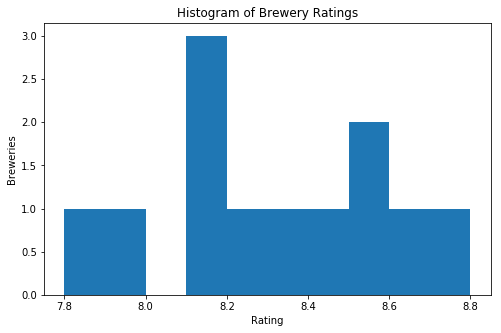

In [509]:
import matplotlib.pyplot as plt

master_list['rating'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Brewery Ratings') # add a title to the histogram
plt.ylabel('Breweries') # add y-label
plt.xlabel('Rating') # add x-label

plt.show()

# Now gather the data for Venues near each brewery and save those for clustering

In [460]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Brewery', 
                  'Brewery Latitude', 
                  'Brewery Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [462]:
# for each brewery, loop on getNearbyVenues and create df with brewery, venue, category, lat, long.

# follow the toronto model of venues
brewery_venues = getNearbyVenues(names=master_list['name'],
                               latitudes=master_list['lat'],
                               longitudes=master_list['lng']
                               )

brewery_venues.head()

Root Down Brewing Company
Workhorse Brewing Co.
Round Guys Brewing Company
Forest & Main Brewing Company
Stable 12 Brewing Company
Conshohocken Brewing Co. Brewpub
Imprint Beer Co.
The Tin Lizard
Stickman Brews
Conshohocken Brewing Company
Sly Fox Brewhouse & Eatery
Bald Birds Brewing Co.


,Brewery,Brewery Latitude,Brewery Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Root Down Brewing Company,40.134446,-75.516047,The Colonial Theatre,40.133856,-75.517464,Indie Movie Theater
1,Root Down Brewing Company,40.134446,-75.516047,Root Down Brewing Company,40.134446,-75.516047,Brewery
2,Root Down Brewing Company,40.134446,-75.516047,Soltane Breads & Spreads,40.134211,-75.513997,Bakery
3,Root Down Brewing Company,40.134446,-75.516047,Iron Hill Brewery & Restaurant,40.134197,-75.513809,Brewery
4,Root Down Brewing Company,40.134446,-75.516047,Black Lab Bistro & Bakery,40.133763,-75.518035,American Restaurant


Let's check how many venues were returned for each neighborhood

In [463]:
print(brewery_venues.shape)

brewery_venues.groupby('Brewery').count()

(251, 7)


,Brewery Latitude,Brewery Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Brewery,,,,,,
Bald Birds Brewing Co.,4,4,4,4,4,4
Conshohocken Brewing Co. Brewpub,9,9,9,9,9,9
Conshohocken Brewing Company,16,16,16,16,16,16
Forest & Main Brewing Company,30,30,30,30,30,30
Imprint Beer Co.,4,4,4,4,4,4
Root Down Brewing Company,50,50,50,50,50,50
Round Guys Brewing Company,22,22,22,22,22,22
Sly Fox Brewhouse & Eatery,16,16,16,16,16,16
Stable 12 Brewing Company,38,38,38,38,38,38


#### Let's find out how many unique categories can be curated from all the returned venues

In [464]:
print('There are {} uniques categories.'.format(len(brewery_venues['Venue Category'].unique())))

There are 92 uniques categories.


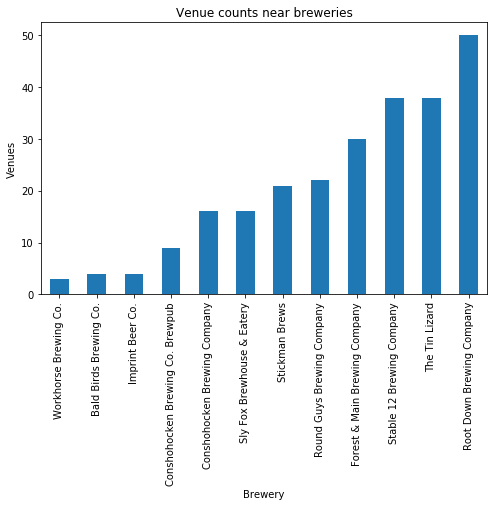

In [526]:
temp_df = brewery_venues.groupby('Brewery').count()
temp_df['Venue'].sort_values().plot(kind='bar', figsize=(8, 5))

plt.title('Venue counts near breweries') # add a title to the histogram
plt.ylabel('Venues') # add y-label
plt.xlabel('Brewery') # add x-label

plt.show()

## Does the rating have any correlation to the number of ratings?
No.

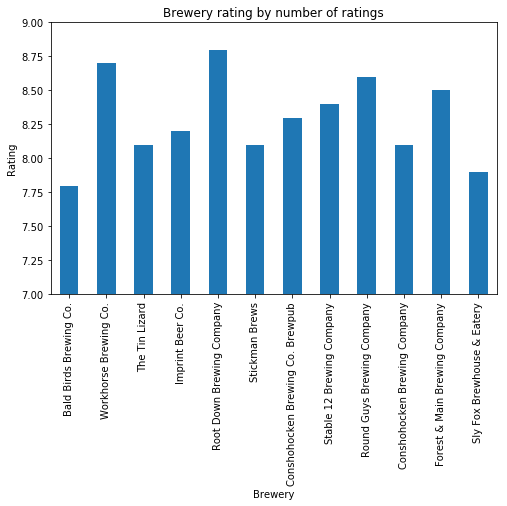

In [534]:
temp_df = brewery_venues.sort_values('ratings', ascending=True)
temp_df.set_index('name', inplace=True)
temp_df['rating'].plot(kind='bar', figsize=(8, 5))

plt.ylim([7, 9])
plt.title('Brewery rating by number of ratings') # add a title to the histogram
plt.ylabel('Rating') # add y-label
plt.xlabel('Brewery') # add x-label

plt.show()

In [546]:
temp_df = brewery_venues.groupby('Venue Category').count()
temp_df.sort_values('Brewery', ascending=False, inplace=True)
temp_df.drop('Brewery', axis=0).head(10)
#temp_df = temp_df.head(10)

,Brewery,Brewery Latitude,Brewery Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Pizza Place,20,20,20,20,20,20
American Restaurant,12,12,12,12,12,12
Italian Restaurant,8,8,8,8,8,8
Pub,7,7,7,7,7,7
Coffee Shop,7,7,7,7,7,7
Bar,6,6,6,6,6,6
Mexican Restaurant,6,6,6,6,6,6
Ice Cream Shop,6,6,6,6,6,6
Bakery,6,6,6,6,6,6


In [ ]:
temp_df.set_index('name', inplace=True)
temp_df['rating'].plot(kind='bar', figsize=(8, 5))

plt.ylim([7, 9])
plt.title('Brewery rating by number of ratings') # add a title to the histogram
plt.ylabel('Rating') # add y-label
plt.xlabel('Brewery') # add x-label

plt.show()

## 3. Analyze Each Brewery cluster

In [465]:
# one hot encoding
venue_onehot = pd.get_dummies(brewery_venues[['Venue Category']], prefix="", prefix_sep="")

# add Brewery column back to dataframe
venue_onehot['Brewery'] = brewery_venues['Brewery'] 

# move Brewery column to the first column
fixed_columns = [venue_onehot.columns[-1]] + list(venue_onehot.columns[:-1])
venue_onehot = venue_onehot[fixed_columns]

venue_onehot.head()

,Yoga Studio,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beer Garden,Beer Store,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Business Service,Café,Candy Store,Chinese Restaurant,Cocktail Bar,Coffee Shop,Convenience Store,Cosmetics Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Farmers Market,Fast Food Restaurant,Food Truck,Fried Chicken Joint,Furniture / Home Store,Gas Station,Gastropub,General Entertainment,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Liquor Store,Locksmith,Martial Arts Dojo,Mediterranean Restaurant,Mexican Restaurant,Mobile Phone Shop,Movie Theater,Music Store,Music Venue,Nail Salon,New American Restaurant,Organic Grocery,Other Great Outdoors,Park,Pharmacy,Pizza Place,Pub,Restaurant,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shipping Store,Smoke Shop,Snack Place,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Thai Restaurant,Theater,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Root Down Brewing Company,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Root Down Brewing Company,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,Root Down Brewing Company,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Root Down Brewing Company,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Root Down Brewing Company,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [466]:
venue_onehot.shape

(251, 92)

#### Next, let's group rows by brewery and by taking the mean of the frequency of occurrence of each category

In [467]:
venue_grouped = venue_onehot.groupby('Brewery').mean().reset_index()
venue_grouped

,Brewery,Yoga Studio,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beer Garden,Beer Store,Bistro,Bookstore,Boutique,Breakfast Spot,Bridal Shop,Business Service,Café,Candy Store,Chinese Restaurant,Cocktail Bar,Coffee Shop,Convenience Store,Cosmetics Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Farmers Market,Fast Food Restaurant,Food Truck,Fried Chicken Joint,Furniture / Home Store,Gas Station,Gastropub,General Entertainment,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Liquor Store,Locksmith,Martial Arts Dojo,Mediterranean Restaurant,Mexican Restaurant,Mobile Phone Shop,Movie Theater,Music Store,Music Venue,Nail Salon,New American Restaurant,Organic Grocery,Other Great Outdoors,Park,Pharmacy,Pizza Place,Pub,Restaurant,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shipping Store,Smoke Shop,Snack Place,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Thai Restaurant,Theater,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop
0,Bald Birds Brewing Co.,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.25,0.000000,0.0000,0.000000,0.000000,0.250000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.25,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Conshohocken Brewing Co. Brewpub,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.111111,0.0000,0.00,0.111111,0.0000,0.000000,0.000000,0.000000,0.111111,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.00,0.000000,0.000000,0.111111,0.0000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.222222,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Conshohocken Brewing Company,0.062500,0.000000,0.000000,0.000000,0.125,0.000000,0.000000,0.000000,0.062500,0.000000,0.062500,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0625,0.00,0.000000,0.0625,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.062500,0.0000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.0000,0.000000,0.000000,0.000000,0.0625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Forest & Main Brewing Company,0.033333,0.066667,0.000000,0.000000,0.000,0.000000,0.033333,0.000000,0.066667,0.000000,0.033333,0.00,0.000000,0.000000,0.000000,0.033333,0.000000,0.0000,0.00,0.033333,0.0000,0.000000,0.000000,0.000000,0.000000,0.00,0.033333,0.00,0.000000,0.033333,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.0000

#### Let's confirm the new size

In [468]:
venue_grouped.shape

(12, 92)

#### Let's print each neighborhood along with the top most common venues

In [469]:
num_top_venues = 10

for hood in venue_grouped['Brewery']:
    print("----"+hood+"----")
    temp = venue_grouped[venue_grouped['Brewery'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bald Birds Brewing Co.----
                     venue  freq
0              Coffee Shop  0.25
1         Business Service  0.25
2     Other Great Outdoors  0.25
3              Music Venue  0.00
4                      Pub  0.00
5              Pizza Place  0.00
6                 Pharmacy  0.00
7                     Park  0.00
8          Organic Grocery  0.00
9  New American Restaurant  0.00


----Conshohocken Brewing Co. Brewpub----
                     venue  freq
0              Pizza Place  0.22
1        Convenience Store  0.11
2           Ice Cream Shop  0.11
3             Liquor Store  0.11
4                      Gym  0.11
5                Gastropub  0.11
6                     Café  0.11
7           Breakfast Spot  0.11
8  New American Restaurant  0.00
9                      Pub  0.00


----Conshohocken Brewing Company----
                venue  freq
0  Athletics & Sports  0.12
1  Italian Restaurant  0.12
2         Yoga Studio  0.06
3                 Bar  0.06
4          Food Truck

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [470]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [498]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Brewery']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
breweries_venues_sorted = pd.DataFrame(columns=columns)
breweries_venues_sorted['Brewery'] = venue_grouped['Brewery']

for ind in np.arange(venue_grouped.shape[0]):
    breweries_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venue_grouped.iloc[ind, :], num_top_venues)

breweries_venues_sorted

,Brewery,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Bald Birds Brewing Co.,Other Great Outdoors,Business Service,Coffee Shop
1,Conshohocken Brewing Co. Brewpub,Pizza Place,Gym,Ice Cream Shop
2,Conshohocken Brewing Company,Italian Restaurant,Athletics & Sports,Yoga Studio
3,Forest & Main Brewing Company,Pizza Place,American Restaurant,Bakery
4,Imprint Beer Co.,Pharmacy,General Entertainment,Business Service
5,Root Down Brewing Company,American Restaurant,Pub,Pizza Place
6,Round Guys Brewing Company,Pizza Place,Ice Cream Shop,Bakery
7,Sly Fox Brewhouse & Eatery,Pizza Place,Fast Food Restaurant,Bank
8,Stable 12 Brewing Company,American Restaurant,Pub,Pizza Place
9,Stickman Brews,Pizza Place,Fast Food Restaurant,Discount Store


## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into clusters.

In [499]:
# set number of clusters
kclusters = 3

venue_grouped_clustering = venue_grouped.drop('Brewery', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venue_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 1, 1, 0, 1, 1, 1, 1, 1])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [500]:
# add clustering labels
breweries_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
breweries_venues_sorted

,Cluster Labels,Brewery,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,0,Bald Birds Brewing Co.,Other Great Outdoors,Business Service,Coffee Shop
1,1,Conshohocken Brewing Co. Brewpub,Pizza Place,Gym,Ice Cream Shop
2,1,Conshohocken Brewing Company,Italian Restaurant,Athletics & Sports,Yoga Studio
3,1,Forest & Main Brewing Company,Pizza Place,American Restaurant,Bakery
4,0,Imprint Beer Co.,Pharmacy,General Entertainment,Business Service
5,1,Root Down Brewing Company,American Restaurant,Pub,Pizza Place
6,1,Round Guys Brewing Company,Pizza Place,Ice Cream Shop,Bakery
7,1,Sly Fox Brewhouse & Eatery,Pizza Place,Fast Food Restaurant,Bank
8,1,Stable 12 Brewing Company,American Restaurant,Pub,Pizza Place
9,1,Stickman Brews,Pizza Place,Fast Food Restaurant,Discount Store


In [501]:
venue_merged = master_list

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
venue_merged = venue_merged.join(breweries_venues_sorted.set_index('Brewery'), on='name')

venue_merged.head() # check the last columns!

,name,categories,address,city,lat,lng,postalCode,id,rating,ratings,likes,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
1,Root Down Brewing Company,Brewery,1 N Main St,Phoenixville,40.134446,-75.516047,19460,5980fde3123a1927c160b4a7,8.8,45,36,1,American Restaurant,Pub,Pizza Place
2,Workhorse Brewing Co.,Brewery,250 King Manor Dr,King of Prussia,40.091376,-75.349277,19406,5b9c1b41911fc4003971ec43,8.7,11,9,2,Breakfast Spot,Food Truck,Wine Shop
10,Round Guys Brewing Company,Brewery,324 W Main St,Lansdale,40.243484,-75.287815,19446,4c38af873849c9289ee5bfb1,8.6,123,91,1,Pizza Place,Ice Cream Shop,Bakery
6,Forest & Main Brewing Company,Brewery,61 N Main St,Ambler,40.155337,-75.225180,19002,4f10714ce4b0d59e1eea5323,8.5,128,93,1,Pizza Place,American Restaurant,Bakery
4,Stable 12 Brewing Company,Brewery,368 Bridge St,Phoenixville,40.132923,-75.520894,19460,54e0ed07498eda4a05ead0b1,8.4,65,45,1,American Restaurant,Pub,Pizza Place


Finally, let's visualize the resulting clusters

In [504]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11, tiles='Stamen Toner')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#Venue	Venue Latitude	Venue Longitude	Venue Category
for lat, lon, ven, cat in zip(brewery_venues['Venue Latitude'], brewery_venues['Venue Longitude'], brewery_venues['Venue'], brewery_venues['Venue Category']):
    label = folium.Popup(str(ven) + ' Cat: ' + str(cat), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7).add_to(map_clusters)
    
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(venue_merged['lat'], venue_merged['lng'], venue_merged['name'], venue_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
          
map_clusters

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. 

### Cluster 1 - Industrial locations.
These are away from other stores and is very similar to cluster 3 except more isolated.

In [495]:
venue_merged.loc[venue_merged['Cluster Labels'] == 0, venue_merged.columns[[0] + list(range(5, venue_merged.shape[1]))]]

,name,lng,postalCode,id,rating,ratings,likes,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Imprint Beer Co.,-75.283990,19440,5a5a8235b9a5a867e3567816,8.2,18,12,0,Pharmacy,General Entertainment,Business Service,Donut Shop,Convenience Store
5,Bald Birds Brewing Co.,-75.416254,19403,5b804a7a46e1b6002c0a1576,7.8,8,6,0,Other Great Outdoors,Business Service,Coffee Shop,Wine Shop,Donut Shop


### Cluster 2 - In town centers near other shops

In [496]:
venue_merged.loc[venue_merged['Cluster Labels'] == 1, venue_merged.columns[[0] + list(range(5, venue_merged.shape[1]))]]

,name,lng,postalCode,id,rating,ratings,likes,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Root Down Brewing Company,-75.516047,19460,5980fde3123a1927c160b4a7,8.8,45,36,1,American Restaurant,Pub,Pizza Place,Cosmetics Shop,Coffee Shop
10,Round Guys Brewing Company,-75.287815,19446,4c38af873849c9289ee5bfb1,8.6,123,91,1,Pizza Place,Ice Cream Shop,Bakery,Convenience Store,Pharmacy
6,Forest & Main Brewing Company,-75.225180,19002,4f10714ce4b0d59e1eea5323,8.5,128,93,1,Pizza Place,American Restaurant,Bakery,Yoga Studio,Ice Cream Shop
4,Stable 12 Brewing Company,-75.520894,19460,54e0ed07498eda4a05ead0b1,8.4,65,45,1,American Restaurant,Pub,Pizza Place,Coffee Shop,Mexican Restaurant
7,Conshohocken Brewing Co. Brewpub,-75.345149,19405,57b4ecff498e96257ec08302,8.3,60,45,1,Pizza Place,Gym,Ice Cream Shop,Gastropub,Café
18,The Tin Lizard,-75.322710,19010,58d70c180b56560fa5e31270,8.1,14,11,1,Pizza Place,Indian Restaurant,Café,Italian Restaurant,Restaurant
13,Stickman Brews,-75.533495,19468,56761391498e0699693a92c6,8.1,48,34,1,Pizza Place,Fast Food Restaurant,Discount Store,Department Store,Beer Store
9,Conshohocken Brewing Company,-75.292353,19428,52bc768d498e457dd1ea97e5,8.1,126,93,1,Italian Restaurant,Athletics & Sports,Yoga Studio,Bakery,Food Truck
12,Sly Fox Brewhouse & Eatery,-75.547670,19460,4b228003f964a520d94724e3,7.9,166,109,1,Pizza Place,Fast Food Restaurant,Bank,Salon / Barbershop,Sandwich Place


### Cluster 3 - Out of the way location.

Workhorse is an odd-ball as it is attached to a large gym away from other locations but fairly residential.

In [497]:
venue_merged.loc[venue_merged['Cluster Labels'] == 2, venue_merged.columns[[0] + list(range(5, venue_merged.shape[1]))]]

,name,lng,postalCode,id,rating,ratings,likes,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Workhorse Brewing Co.,-75.349277,19406,5b9c1b41911fc4003971ec43,8.7,11,9,2,Breakfast Spot,Food Truck,Wine Shop,Donut Shop,Convenience Store


# Find Target locations

finally, let's find a location that has the positive criteria and avoids the negative

##### Worst Rated Breweries Proximity to:
* Fast Food 
* Business Services 
##### Best Rated Breweries Proximity to: 
* American Restaurants 
* Pubs 



In [606]:
radius = 5000   
latitude =  40.177757
longitude = -75.308985
'''
American Restaurant    4bf58dd8d48988d14e941735
pub                    4bf58dd8d48988d11b941735
Fast Food Restaurant   4bf58dd8d48988d16e941735
Business Service       5453de49498eade8af355881  
'''

categoryId = '4bf58dd8d48988d14e941735'  # American Restaurant
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}&intent=browse'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, categoryId, radius, LIMIT)
results = requests.get(url).json()
target_venues = results['response']['venues']
good_targets1 = json_normalize(target_venues)

categoryId = '4bf58dd8d48988d11b941735'  # Pub
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}&intent=browse'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, categoryId, radius, LIMIT)
results = requests.get(url).json()
target_venues = results['response']['venues']
good_targets2 = json_normalize(target_venues)

# combine the dataframes
good_targets = pd.concat([good_targets1, good_targets2], ignore_index=True, sort=False)

In [607]:
# do it again in second area 

latitude =  40.199503   
longitude = -75.343532

categoryId = '4bf58dd8d48988d14e941735'  # American Restaurant
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}&intent=browse'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, categoryId, radius, LIMIT)
results = requests.get(url).json()
target_venues = results['response']['venues']
good_targets1 = json_normalize(target_venues)

categoryId = '4bf58dd8d48988d11b941735'  # Pub
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}&intent=browse'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, categoryId, radius, LIMIT)
results = requests.get(url).json()
target_venues = results['response']['venues']
good_targets2 = json_normalize(target_venues)

good_targets = pd.concat([good_targets, good_targets1, good_targets2], ignore_index=True, sort=False)

In [608]:
# do it again in third area 

latitude =  40.100479   
longitude = -75.237758

categoryId = '4bf58dd8d48988d14e941735'  # American Restaurant
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}&intent=browse'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, categoryId, radius, LIMIT)
results = requests.get(url).json()
target_venues = results['response']['venues']
good_targets1 = json_normalize(target_venues)

categoryId = '4bf58dd8d48988d11b941735'  # Pub
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}&intent=browse'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, categoryId, radius, LIMIT)
results = requests.get(url).json()
target_venues = results['response']['venues']
good_targets2 = json_normalize(target_venues)

In [609]:
# combine the dataframes
good_targets = pd.concat([good_targets, good_targets1, good_targets2], ignore_index=True, sort=False)

# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in good_targets.columns if col.startswith('location.')] + ['id']
good_targets_filtered = good_targets.loc[:, filtered_columns]

# filter the category for each row
good_targets_filtered['categories'] = good_targets_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
good_targets_filtered.columns = [column.split('.')[-1] for column in good_targets_filtered.columns]

In [610]:
# fake locations
indexNames = good_targets_filtered[good_targets_filtered['name']=='Spinnerstown Inn'].index
good_targets_filtered.drop(indexNames, inplace=True)
indexNames = good_targets_filtered[good_targets_filtered['name']=='Mahhhtins'].index
good_targets_filtered.drop(indexNames, inplace=True)

# Bad locations now



In [611]:
radius = 5000   
latitude =  40.177757
longitude = -75.308985
'''
American Restaurant    4bf58dd8d48988d14e941735
pub                    4bf58dd8d48988d11b941735
Fast Food Restaurant   4bf58dd8d48988d16e941735
Business Service       5453de49498eade8af355881  
'''

categoryId = '4bf58dd8d48988d16e941735'  # Fast Food 
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}&intent=browse'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, categoryId, radius, LIMIT)
results = requests.get(url).json()
target_venues = results['response']['venues']
bad_targets1 = json_normalize(target_venues)

categoryId = '5453de49498eade8af355881'  # Business Service
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}&intent=browse'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, categoryId, radius, LIMIT)
results = requests.get(url).json()
target_venues = results['response']['venues']
bad_targets2 = json_normalize(target_venues)

# combine the dataframes
bad_targets = pd.concat([bad_targets1, bad_targets2], ignore_index=True, sort=False)

In [612]:
# do it again in second area 

latitude =  40.199503   
longitude = -75.343532

categoryId = '4bf58dd8d48988d16e941735'  # Fast Food 
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}&intent=browse'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, categoryId, radius, LIMIT)
results = requests.get(url).json()
target_venues = results['response']['venues']
bad_targets1 = json_normalize(target_venues)

categoryId = '5453de49498eade8af355881'  # Business Service
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}&intent=browse'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, categoryId, radius, LIMIT)
results = requests.get(url).json()
target_venues = results['response']['venues']
bad_targets2 = json_normalize(target_venues)

# combine the dataframes
bad_targets = pd.concat([bad_targets, bad_targets1, bad_targets2], ignore_index=True, sort=False)

In [613]:
# do it again in third area 
latitude =  40.100479   
longitude = -75.237758

categoryId = '4bf58dd8d48988d16e941735'  # Fast Food 
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}&intent=browse'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, categoryId, radius, LIMIT)
results = requests.get(url).json()
target_venues = results['response']['venues']
bad_targets1 = json_normalize(target_venues)

categoryId = '5453de49498eade8af355881'  # Business Service
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}&intent=browse'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, categoryId, radius, LIMIT)
results = requests.get(url).json()
target_venues = results['response']['venues']
bad_targets2 = json_normalize(target_venues)


In [614]:
# combine the dataframes
bad_targets = pd.concat([bad_targets, bad_targets1, bad_targets2], ignore_index=True, sort=False)

# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in bad_targets.columns if col.startswith('location.')] + ['id']
bad_targets_filtered = bad_targets.loc[:, filtered_columns]

# filter the category for each row
bad_targets_filtered['categories'] = bad_targets_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
bad_targets_filtered.columns = [column.split('.')[-1] for column in bad_targets_filtered.columns]

In [632]:
# locations which are mismarked in Foursquare data by my assessment.
indexNames = bad_targets_filtered[bad_targets_filtered['name']=='Content by Christa LLC'].index
bad_targets_filtered.drop(indexNames, inplace=True)
indexNames = bad_targets_filtered[bad_targets_filtered['name']=='The Cedars House Cafe'].index
bad_targets_filtered.drop(indexNames, inplace=True)



In [633]:
# finally add the 3 target locations that are noted in the search
#prime_locations = [42, 27, 48]
prime_locations = good_targets_filtered.loc[np.r_[42, 27, 48]]
prime_locations

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
42,The Phil's Tavern,Bar,931 Butler Pike,US,Blue Bell,United States,NaN,4282,"[931 Butler Pike, Blue Bell, PA 19422, United ...","[{'label': 'display', 'lat': 40.13857460339311...",40.138575,-75.244752,19422,PA,4b48d68bf964a5205d5926e3
27,The Farm House Restaurant,American Restaurant,1146 Stump Hall,US,Skippack,United States,NaN,3756,"[1146 Stump Hall, Skippack, PA 19474, United S...","[{'label': 'display', 'lat': 40.20792614337953...",40.207926,-75.386322,19474,PA,4dcdc92bd22deadedd425d7b
48,Knishes And Dishes,American Restaurant,NaN,US,Whitemarsh,United States,NaN,1948,"[Whitemarsh, PA, United States]","[{'label': 'display', 'lat': 40.0862970834841,...",40.086297,-75.251172,NaN,PA,529e439d11d20d4ef3d2b1e6


In [634]:
# create map

final_map = folium.Map(location=[latitude, longitude], zoom_start=10)  
mont_geo = r'PaMunicipalities2019_46.json'

final_map.choropleth(
    geo_data=mont_geo,
    data=neighborhoods,
    columns=['Townships', 'Population 2010'],
    key_on='feature.properties.MUNICIPAL1',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
)

for lat, lng, label in zip(good_targets_filtered.lat, good_targets_filtered.lng, good_targets_filtered.name):
    folium.CircleMarker(
        [lat, lng],
        radius=15,
        color='green',
        popup=label,
        fill = True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(final_map)
    
for lat, lng, label in zip(bad_targets_filtered.lat, bad_targets_filtered.lng, bad_targets_filtered.name):
    folium.CircleMarker(
        [lat, lng],
        radius=15,
        color='red',
        popup=label,
        fill = True,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(final_map)
    
    
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.name):
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(final_map)

for lat, lng, label in zip(prime_locations.lat, prime_locations.lng, prime_locations.name):
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        color='yellow',
        popup=label,
        fill = True,
        fill_color='yellow',
        fill_opacity=0.6
    ).add_to(final_map)
    
final_map